# CARMENES / CARM_VIS DATABASE LOADING AND INSPECTION
In this notebook we locate CARMENES objects (from CARM_VIS data, i.e. NZP-corrected) in instability strips and check for missing light curve data.

We also generate two file copies with only the applicable objects. The second copy will be used to fill in the periodogram calculations.

## Modules and configuration

### Modules

In [1]:
# Modules import:
import numpy as np

import pandas as pd
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [2]:
# Configuration:
# Files:
INPUT_FILE = "../data/carmencita.102_mod_CARM_VIS.csv"
SYNTH_POP_FILE = "../data/Auxiliary_data/ETLed__NoLimit_TFM_02_MW_2022-01-13-19-18-22_hdr.csv"
OUTPUT_FILE = "../data/carmencita.102_mod_CARM_VIS.csv"
GTO_OUTPUT_FILE = "../data/CARM_VIS_objects.csv"
GTO_OUT_PG_FILE = "../data/CARM_VIS_objects_with_PG.csv"
GTO_NAN_RECORD_FILE = "../data/CARM_VIS_NaN_logg_objects.csv"
GTO_NAN_FILE = "../data/CARM_VIS_NaN_Count.csv"
GTO_NO_LC_FILE = "../data/CARM_VIS_With_no_LC_Data.csv"

IMAGE_NOMINAL_OUT = "./img/ETL_11_01_CARM_VIS_Instability_bands_Nominal.png"
IMAGE_RANGED_OUT = "./img/ETL_11_02_CARM_VIS_Instability_bands_Ranged.png"
IMAGE_RANGED_OUT_FULL_HR = "./img/ETL_11_03_CARM_VIS_Instability_bands_Ranged_Full_HR.png"
IMAGE_RANGED_OUT_ZOOM_HR = "./img/ETL_11_03B_CARM_VIS_Instability_bands_Ranged_Zoom_HR.png"
IMAGE_NO_LC_GTO_LOCATION = "./img/ETL_11_04_Location_of_CARM_VIS_without_LC.png"
IMAGE_NO_LC_GTO_LOCATION_AITOFF = "./img/ETL_11_04B_AITOFF_Location_of_CARM_VIS_without_LC.png"
IMAGE_HR_TEFF = "./img/ETL_11_05_Carmenes_objects_in_HR_diagram.png"

# Instability bands:
INST_B = {
    'D-burning': {
        'logg': {
            'min': 3.1,
            'max': 3.6
        },
        'Teff': {
            'min': 2800,
            'max': 3500
        }
    },
    'He3-burning': {
        'logg': {
            'min': 4.5,
            'max': 5.1
        },
        'Teff': {
            'min': 3300,
            'max': 4300
        }
    }
}

# Star physical parameters:
PHYS_PARAMS = []



## Data loading

### Load CARMENES data

In [3]:
carmenes = pd.read_csv(INPUT_FILE, sep=',', decimal='.')
carmenes.head()

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,TIC_id,Teff_min_K,Teff_max_K,logg_min,logg_max,is_GTO,rv_file,lc_file,has_rv,has_lc
0,J23598+477,LP 149-014,-,4385,359.962056,47.761478,23:59:49.51,+47:45:44.5,114.027674,-14.216353,...,177697529,2950.0,3050.0,4.50,5.50,False,NaN,NaN,False,False
1,J23590+208,G 129-051,-,NaN,359.753066,20.860336,23:59:00.42,+20:51:39.0,106.785616,-40.361996,...,2053997903,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False
2,J23587+467,BD+45 4378 AB,AB,913,359.685432,46.729152,23:58:43.49,+46:43:44.7,113.616244,-15.187224,...,2041238829,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False
3,J23585+076,Wolf 1051,AB,4383,359.636420,7.656947,23:58:32.65,+07:39:30.1,100.839686,-52.931049,...,408486498,3476.0,3516.0,4.89,5.05,True,../data/CARM_VIS_RVs/J23585+076.avc.dat,NaN,True,False
4,J23582-174,LP 764-040,AB,NaN,359.558095,-17.409041,23:58:13.69,-17:24:32.9,68.527865,-74.336758,...,2052312661,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False


In [4]:
print(carmenes.columns.tolist())

['Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg', 'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg', 'Ref01', 'SpT', 'SpTnum', 'Ref02', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'Ref03', 'L_Lsol', 'eL_Lsol', 'Ref04', 'R_Rsol', 'eR_Rsol', 'Ref05', 'M_Msol', 'eM_Msol', 'Ref06', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'Ref07', 'pi_mas', 'epi_mas', 'Ref08', 'd_pc', 'ed_pc', 'Ref09', 'Vr_kms-1', 'eVr_kms-1', 'Ref10', 'ruwe', 'Ref11', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'Ref12', 'sa_m/s/a', 'esa_m/s/a', 'Ref13', 'SKG', 'Ref14', 'SKG_lit', 'Ref14_lit', 'Pop', 'Ref15', 'vsini_flag', 'vsini_kms-1', 'evsini_kms-1', 'Ref16', 'P_d', 'eP_d', 'Ref17', 'pEWHalpha_A', 'epEWHalpha_A', 'Ref18', 'log(LHalpha/Lbol)', 'elog(LHalpha/Lbol)', 'Ref19', '1RXS', 'CRT_s-1', 'eCRT_s-1', 'HR1', 'eHR1', 'HR2', 'eHR2', 'Flux_X_E-13_ergcm-2s-1', 'eFlux_X_E-13_ergcm-2s-1', 'LX/LJ', 'eLX/LJ', 'Ref20', 'Activity', 'Ref21', 'FUV_mag',

### Load synthetic stellar population

This is a synthetic star population generated with BaSTI tool (http://basti-iac.oa-abruzzo.inaf.it/), with the following parameters:

\##########################################

\#     STAR FORMATION HISTORY              

\#                                         

\# t(Gyr)relative SFR [Fe/H]sigma([Fe/H])  

\#  9.50000  1.00000 -1.27000  0.30000

\#  7.00000  0.00000  0.00000  0.00000

\#  5.00000  0.98165 -0.55000  0.15000

\#  2.00000  0.00000  0.00000  0.00000

\#  1.00000  0.75229  0.00000  0.10000

\#  0.02000  0.75229  0.00000  0.10000

\##########################################

\#Model: Scaled solar models & Sloan transformations                        

\#Model: Overshooting: True, Diffusion: True, Mass loss: True, He: 0.247    

\##########################################

The file has been previously preprocessed with notebook `ETL_07_BaSTI_SynthPop_File_Preprocessing_v2.0.ipynb`

In [5]:
stellar_pop = pd.read_csv(SYNTH_POP_FILE, sep=',', decimal='.')
stellar_pop.head()

,star_number,log(t[years]),Metallicity[Fe/H],Mass[Mo],log(L/Lo),log(Teff[K]),InitMassSec[Mo],VarStarIdx,Pulsating_log(P[days]),u,...,g-r,r-i,i-z,log_g,Teff,Age [Gyr],Age Range [Gyr],ID Age Range,Metallicity Range [Fe/H],ID Metallicity Range
0,1,9.924415,-1.4575,0.1090,-2.8361,3.5084,0.0928,0,99.99,18.0943,...,1.8538,0.8023,0.4662,5.296607,3224.036872,8.402622,from 7.5 to 10.0 Gyr,Age_3,from -2.0 to -1.0 [Fe/H],Met_1
1,2,9.947005,-1.2202,0.1081,-2.8307,3.5138,0.0867,0,99.99,17.9405,...,1.8141,0.7850,0.4546,5.309206,3264.374675,8.851255,from 7.5 to 10.0 Gyr,Age_3,from -2.0 to -1.0 [Fe/H],Met_1
2,4,9.913869,-0.7478,0.2711,-1.8518,3.5874,0.2057,0,99.99,13.1454,...,1.4078,0.5379,0.3096,5.024010,3867.229981,8.201037,from 7.5 to 10.0 Gyr,Age_3,from -1.0 to -0.5 [Fe/H],Met_2
3,6,9.965860,-1.0048,0.2449,-1.8871,3.5979,0.2222,0,99.99,12.7719,...,1.2943,0.5010,0.2886,5.057169,3961.867984,9.244008,from 7.5 to 10.0 Gyr,Age_3,from -2.0 to -1.0 [Fe/H],Met_1
4,8,9.919496,-1.4860,0.1656,-2.2855,3.5691,0.1339,0,99.99,14.7574,...,1.6028,0.6053,0.3360,5.170441,3707.660840,8.308000,from 7.5 to 10.0 Gyr,Age_3,from -2.0 to -1.0 [Fe/H],Met_1


In [6]:
stellar_pop.columns

Index(['star_number', 'log(t[years])', 'Metallicity[Fe/H]', 'Mass[Mo]',
       'log(L/Lo)', 'log(Teff[K])', 'InitMassSec[Mo]', 'VarStarIdx',
       'Pulsating_log(P[days])', 'u', 'g', 'r', 'i', 'z', 'u-g', 'g-r', 'r-i',
       'i-z', 'log_g', 'Teff', 'Age [Gyr]', 'Age Range [Gyr]', 'ID Age Range',
       'Metallicity Range [Fe/H]', 'ID Metallicity Range'],
      dtype='object')

## Mark instability band (if appropriate)

### With nominal values (using just `logg` variable)

In [7]:
carmenes['InstBand_nominal'] = "none"

In [8]:
# Mark stars in instability bands (using nominal values):
for ib in INST_B.keys():
    carmenes.loc[(carmenes['logg'] >= INST_B[ib]['logg']['min']) &
                 (carmenes['logg'] <= INST_B[ib]['logg']['max']) &
                 (carmenes['Teff_K'] >= INST_B[ib]['Teff']['min']) &
                 (carmenes['Teff_K'] <= INST_B[ib]['Teff']['max']),
                 'InstBand_nominal'] = ib

carmenes.head()

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,Teff_min_K,Teff_max_K,logg_min,logg_max,is_GTO,rv_file,lc_file,has_rv,has_lc,InstBand_nominal
0,J23598+477,LP 149-014,-,4385,359.962056,47.761478,23:59:49.51,+47:45:44.5,114.027674,-14.216353,...,2950.0,3050.0,4.50,5.50,False,NaN,NaN,False,False,none
1,J23590+208,G 129-051,-,NaN,359.753066,20.860336,23:59:00.42,+20:51:39.0,106.785616,-40.361996,...,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False,none
2,J23587+467,BD+45 4378 AB,AB,913,359.685432,46.729152,23:58:43.49,+46:43:44.7,113.616244,-15.187224,...,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False,none
3,J23585+076,Wolf 1051,AB,4383,359.636420,7.656947,23:58:32.65,+07:39:30.1,100.839686,-52.931049,...,3476.0,3516.0,4.89,5.05,True,../data/CARM_VIS_RVs/J23585+076.avc.dat,NaN,True,False,He3-burning
4,J23582-174,LP 764-040,AB,NaN,359.558095,-17.409041,23:58:13.69,-17:24:32.9,68.527865,-74.336758,...,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False,none


Check the total number of stars in instability bands (nominal):

In [9]:
carmenes['InstBand_nominal'].value_counts()

none           1231
He3-burning     981
Name: InstBand_nominal, dtype: int64

**OBSERVATION:** no star at all is in the instability strip of _"D-burning"_ cases.

Check the GTO stars in instability bands (nominal):

In [10]:
carmenes.loc[carmenes['is_GTO'] == True, 'InstBand_nominal'].value_counts()

He3-burning    243
none           147
Name: InstBand_nominal, dtype: int64

### With ranged values (including  `elogg` variable)

We first check the max values of `eTeff_K` and `elogg`, just in case the instability bands could overlap and hence provoke ambiguous band assignation.

In [11]:
INST_B

{'D-burning': {'logg': {'min': 3.1, 'max': 3.6},
  'Teff': {'min': 2800, 'max': 3500}},
 'He3-burning': {'logg': {'min': 4.5, 'max': 5.1},
  'Teff': {'min': 3300, 'max': 4300}}}

In [12]:
carmenes[['eTeff_K', 'elogg']].describe()

,eTeff_K,elogg
count,1657.000000,1652.000000
mean,45.379602,0.410533
std,11.216744,0.160944
min,9.000000,0.030000
25%,50.000000,0.500000
50%,50.000000,0.500000
75%,50.000000,0.500000
max,97.000000,0.500000


Maximum value of `elogg` is $0.5$, so the assignment to instability bands will not be ambiguous.

In [13]:
carmenes.columns

Index(['Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg',
       'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg',
       ...
       'Teff_min_K', 'Teff_max_K', 'logg_min', 'logg_max', 'is_GTO', 'rv_file',
       'lc_file', 'has_rv', 'has_lc', 'InstBand_nominal'],
      dtype='object', length=185)

In [14]:
carmenes['InstBand_ranged'] = "none"

In [15]:
# Mark stars in instability bands (ussing range of values):
for ib in INST_B.keys():
    mask_range_logg = ((carmenes['logg_min'] >= INST_B[ib]['logg']['min']) & \
                   (carmenes['logg_min'] <= INST_B[ib]['logg']['max'])) | \
                ((carmenes['logg_max'] >= INST_B[ib]['logg']['min']) & \
                 (carmenes['logg_max'] <= INST_B[ib]['logg']['max']))
    mask_range_Teff = ((carmenes['Teff_min_K'] >= INST_B[ib]['Teff']['min']) & \
                   (carmenes['Teff_min_K'] <= INST_B[ib]['Teff']['max'])) | \
                ((carmenes['Teff_max_K'] >= INST_B[ib]['Teff']['min']) & \
                 (carmenes['Teff_max_K'] <= INST_B[ib]['Teff']['max']))
    carmenes.loc[mask_range_logg & mask_range_Teff,
                 'InstBand_ranged'] = ib

carmenes.head()

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,Teff_max_K,logg_min,logg_max,is_GTO,rv_file,lc_file,has_rv,has_lc,InstBand_nominal,InstBand_ranged
0,J23598+477,LP 149-014,-,4385,359.962056,47.761478,23:59:49.51,+47:45:44.5,114.027674,-14.216353,...,3050.0,4.50,5.50,False,NaN,NaN,False,False,none,none
1,J23590+208,G 129-051,-,NaN,359.753066,20.860336,23:59:00.42,+20:51:39.0,106.785616,-40.361996,...,NaN,NaN,NaN,False,NaN,NaN,False,False,none,none
2,J23587+467,BD+45 4378 AB,AB,913,359.685432,46.729152,23:58:43.49,+46:43:44.7,113.616244,-15.187224,...,NaN,NaN,NaN,False,NaN,NaN,False,False,none,none
3,J23585+076,Wolf 1051,AB,4383,359.636420,7.656947,23:58:32.65,+07:39:30.1,100.839686,-52.931049,...,3516.0,4.89,5.05,True,../data/CARM_VIS_RVs/J23585+076.avc.dat,NaN,True,False,He3-burning,He3-burning
4,J23582-174,LP 764-040,AB,NaN,359.558095,-17.409041,23:58:13.69,-17:24:32.9,68.527865,-74.336758,...,NaN,NaN,NaN,False,NaN,NaN,False,False,none,none


Check the total number of stars in instability bands (ranged):

In [16]:
carmenes['InstBand_ranged'].value_counts()

He3-burning    1157
none           1055
Name: InstBand_ranged, dtype: int64

Check the GTO stars in instability bands (ranged):

In [17]:
carmenes.loc[carmenes['is_GTO'] == True, 'InstBand_ranged'].value_counts()

He3-burning    279
none           111
Name: InstBand_ranged, dtype: int64

### Summary of stats

In [18]:
carmenes[['is_GTO', 'InstBand_nominal', 'Karmn']] \
    .groupby(by=['is_GTO', 'InstBand_nominal']).count()

Karmn
is_GTO InstBand_nominal       
False  He3-burning         738
       none               1084
True   He3-burning         243
       none                147

In [19]:
carmenes[['is_GTO', 'InstBand_ranged', 'Karmn']] \
    .groupby(by=['is_GTO', 'InstBand_ranged']).count()

Karmn
is_GTO InstBand_ranged       
False  He3-burning        878
       none               944
True   He3-burning        279
       none               111

### Check `NaN` values

Check `Nan` values of the data (`Teff_K` and `logg`variables):

In [20]:
carmenes[['Teff_K', 'logg']].isna().sum().reset_index()

,index,0
0,Teff_K,555
1,logg,560


In [21]:
carmenes.shape

(2212, 186)

Hence, about $25\%$ of the whole dataset is missing `logg` and/or `Teff` values.

In [22]:
carmenes[carmenes['is_GTO'] == True][['Teff_K', 'logg']].isna().sum().reset_index()

,index,0
0,Teff_K,0
1,logg,4


In [23]:
carmenes[carmenes['is_GTO'] == True].shape

(390, 186)

Hence, only about $1\%$ is missing `logg` values.

In [24]:
gto_nan_logg_teff = carmenes[(carmenes['is_GTO'] == True) &
                            ((carmenes['logg'].isna()) | (carmenes['Teff_K'].isna()))].copy()
gto_nan_logg_teff

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,Teff_max_K,logg_min,logg_max,is_GTO,rv_file,lc_file,has_rv,has_lc,InstBand_nominal,InstBand_ranged
180,J22102+587,TOI-2285,-,NaN,332.563270,58.706090,22:10:15.14,+58:42:22.2,103.288489,2.123561,...,3550.0,NaN,NaN,True,../data/CARM_VIS_RVs/J22102+587.avc.dat,../data/CARMENES_GTO_TESS_lc/lightcurves/J2210...,True,True,none,none
345,J20109+708,TYC 4450-1440-1,-,NaN,302.737507,70.869661,20:10:57.12,+70:52:09.8,103.864573,19.367775,...,4550.0,NaN,NaN,True,../data/CARM_VIS_RVs/J20109+708.avc.dat,../data/CARMENES_GTO_TESS_lc/lightcurves/J2010...,True,True,none,none
436,J19025+754,LSPM J1902+7525,-,NaN,285.636636,75.418511,19:02:31.93,+75:25:07.0,106.755821,25.495532,...,3750.0,NaN,NaN,True,../data/CARM_VIS_RVs/J19025+754.avc.dat,../data/CARMENES_GTO_TESS_lc/lightcurves/J1902...,True,True,none,none
1282,J09286-121,G 161-32,-,NaN,142.173451,-12.167219,09:28:41.58,-12:09:55.1,244.789722,27.071193,...,3550.0,NaN,NaN,True,../data/CARM_VIS_RVs/J09286-121.avc.dat,../data/CARMENES_GTO_TESS_lc/lightcurves/J0928...,True,True,none,none


Check `Nan` values in any of the variables

In [25]:
gto_nan = carmenes[carmenes['is_GTO'] == True].isna().sum()
gto_nan = gto_nan[gto_nan > 0]
gto_nan

GJ              95
l_J2016_deg      1
b_J2016_deg      1
logg             4
elogg            4
              ... 
Survey           4
Notes          345
logg_min         4
logg_max         4
lc_file        123
Length: 132, dtype: int64

In [26]:
print(gto_nan.index.to_list())

['GJ', 'l_J2016_deg', 'b_J2016_deg', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'R_Rsol', 'eR_Rsol', 'Ref05', 'M_Msol', 'eM_Msol', 'Ref06', 'pi_mas', 'epi_mas', 'Ref08', 'Vr_kms-1', 'eVr_kms-1', 'Ref10', 'ruwe', 'Ref11', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'Ref12', 'sa_m/s/a', 'esa_m/s/a', 'Ref13', 'SKG', 'Ref14', 'SKG_lit', 'Ref14_lit', 'Pop', 'Ref15', 'vsini_flag', 'vsini_kms-1', 'evsini_kms-1', 'Ref16', 'P_d', 'eP_d', 'Ref17', 'pEWHalpha_A', 'epEWHalpha_A', 'Ref18', 'log(LHalpha/Lbol)', 'elog(LHalpha/Lbol)', 'Ref19', '1RXS', 'CRT_s-1', 'eCRT_s-1', 'HR1', 'eHR1', 'HR2', 'eHR2', 'Flux_X_E-13_ergcm-2s-1', 'eFlux_X_E-13_ergcm-2s-1', 'LX/LJ', 'eLX/LJ', 'Ref20', 'Activity', 'Ref21', 'FUV_mag', 'eFUV_mag', 'NUV_mag', 'eNUV_mag', 'Ref22', 'u_mag', 'eu_mag', 'Ref23', 'BT_mag', 'eBT_mag', 'Ref24', 'B_mag', 'eB_mag', 'Ref25', 'g_mag', 'eg_mag', 'Ref27', 'VT_mag', 'eVT_mag', 'Ref28', 'V_mag', 'eV_mag', 'Ref29', 'Ra_mag', 'Ref30', 'r_mag', 'er_mag', 'Ref31', 'i_mag', 

In [27]:
len(gto_nan)

132

### CARM_VIS objects without light curve data

In [28]:
gto_no_lc = carmenes[(carmenes['is_GTO'] == True) &
                     (carmenes['has_lc'] == False)].copy()
gto_no_lc.shape

(123, 186)

Grouped by instability band or not:

In [29]:
gto_no_lc[['Karmn', 'InstBand_ranged']].groupby('InstBand_ranged').count()

,Karmn
InstBand_ranged,
He3-burning,82
none,41


## Data visualization

In [30]:
gto = carmenes[carmenes['is_GTO'] == True].copy()

gto.shape

(390, 186)

### Only CARM_VIS objects (_zoom_)

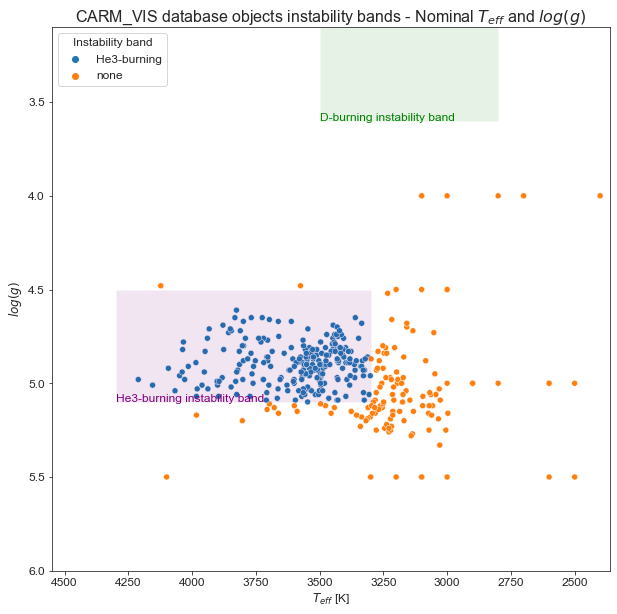

In [31]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=gto, x='Teff_K', y='logg', hue='InstBand_nominal')
# Set plot limits as per global CARMENES data values.
x_min = min([INST_B['He3-burning']['Teff']['min'], INST_B['D-burning']['Teff']['min'],
             carmenes['Teff_min_K'].min()])
x_max = max([INST_B['He3-burning']['Teff']['max'], INST_B['D-burning']['Teff']['max'],
             carmenes['Teff_max_K'].max()])
y_min = min([INST_B['He3-burning']['logg']['min'], INST_B['D-burning']['logg']['min'],
             carmenes['logg_min'].min()])
y_max = max([INST_B['He3-burning']['logg']['max'], INST_B['D-burning']['logg']['max'],
             carmenes['logg_max'].max()])
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
# Add and label instability regions:
ax.add_patch(mpatches.Rectangle((2800, 3.1), 700, 0.5, facecolor="green", alpha=0.10))
ax.text(3500, 3.6, "D-burning instability band", color="green", fontsize=12)
ax.add_patch(mpatches.Rectangle((3300, 4.5), 1000, 0.6, facecolor="purple", alpha=0.10))
ax.text(4300, 5.1, "He3-burning instability band", color="purple", fontsize=12)
# Set titles, sizes etc.
ax.set_title("CARM_VIS database objects instability bands - Nominal $T_{eff}$ and $log(g)$", fontsize=16)
ax.set_xlabel("$T_{eff}$ [K]", fontsize=12)
ax.set_ylabel("$log(g)$", fontsize=12)
ax.tick_params(axis='both', which='major', bottom=True, left=True, labelsize=12)
ax.invert_xaxis()
ax.invert_yaxis()
plt.legend(title="Instability band", title_fontsize='large',
           loc='best', fontsize=12)
plt.savefig(IMAGE_NOMINAL_OUT)
plt.show();

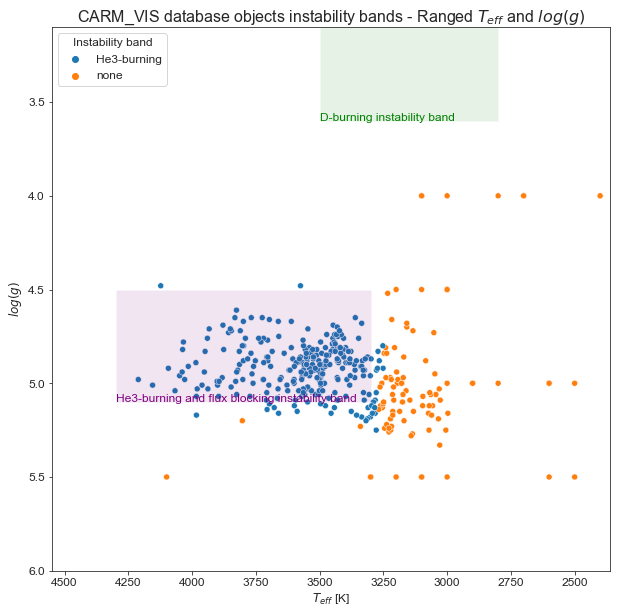

In [32]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=gto, x='Teff_K', y='logg', hue='InstBand_ranged')
# Set plot limits as per global CARMENES data values.
x_min = min([INST_B['He3-burning']['Teff']['min'], INST_B['D-burning']['Teff']['min'],
             carmenes['Teff_min_K'].min()])
x_max = max([INST_B['He3-burning']['Teff']['max'], INST_B['D-burning']['Teff']['max'],
             carmenes['Teff_max_K'].max()])
y_min = min([INST_B['He3-burning']['logg']['min'], INST_B['D-burning']['logg']['min'],
             carmenes['logg_min'].min()])
y_max = max([INST_B['He3-burning']['logg']['max'], INST_B['D-burning']['logg']['max'],
             carmenes['logg_max'].max()])
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
# Add and label instability regions:
ax.add_patch(mpatches.Rectangle((2800, 3.1), 700, 0.5, facecolor="green", alpha=0.10))
ax.text(3500, 3.6, "D-burning instability band", color="green", fontsize=12)
ax.add_patch(mpatches.Rectangle((3300, 4.5), 1000, 0.6, facecolor="purple", alpha=0.10))
ax.text(4300, 5.1, "He3-burning and flux blocking instability band", color="purple", fontsize=12)
# Set titles, sizes etc.
ax.set_title("CARM_VIS database objects instability bands - Ranged $T_{eff}$ and $log(g)$", fontsize=16)
ax.set_xlabel("$T_{eff}$ [K]", fontsize=12)
ax.set_ylabel("$log(g)$", fontsize=12)
ax.tick_params(axis='both', which='major', bottom=True, left=True, labelsize=12)
ax.invert_xaxis()
ax.invert_yaxis()
plt.legend(title="Instability band", title_fontsize='large',
           loc='best', fontsize=12)
plt.savefig(IMAGE_RANGED_OUT)
plt.show();

### Only CARM_VIS objects (HR diagram typical ranges)

In [33]:
gto[['Teff_K', 'logg']].describe()

,Teff_K,logg
count,390.000000,386.000000
mean,3443.284615,4.939715
std,301.324435,0.230902
min,2400.000000,4.000000
25%,3254.500000,4.840000
50%,3457.500000,4.940000
75%,3599.000000,5.060000
max,4500.000000,5.500000


In [34]:
stellar_pop[['Teff', 'log_g']].describe()

,Teff,log_g
count,264732.000000,264732.000000
mean,3611.013316,5.070244
std,712.185099,0.220097
min,2742.837004,0.665406
25%,3218.103443,5.003494
50%,3477.763139,5.110949
75%,3767.905482,5.214531
max,20365.730854,5.385102


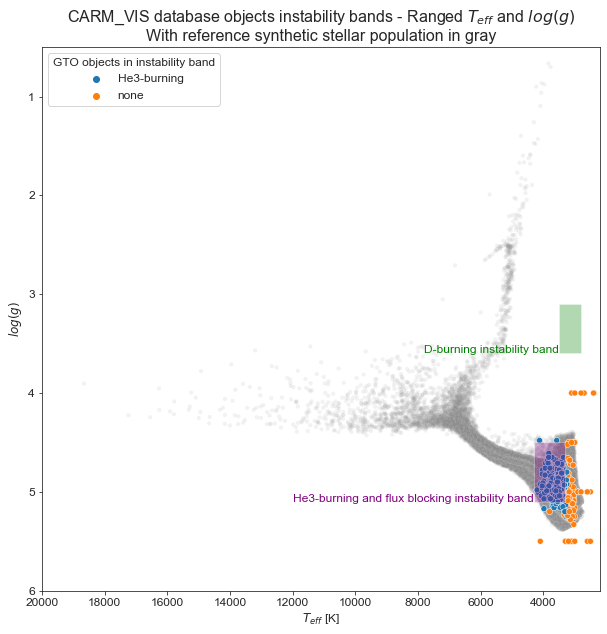

In [35]:
plt.figure(figsize=(10,10))
#ax = sns.scatterplot(data=gto, x='Teff_K', y='logg', hue='InstBand_ranged')
# Draw the synthetic population:
ax = sns.scatterplot(data=stellar_pop, x='Teff', y='log_g', color='gray', size=1.0, alpha=0.1,
                     legend=False)

# Set plot limits as per typical logg and Teff values in HR diagram.
x_min = 2200
x_max = 20000
y_min = 0.50
y_max = 6.00
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

# Add the synthetic population:
#sns.scatterplot(data=stellar_pop, x='Teff', y='log_g', color='gray', size=1.0, alpha=0.1,
#                ax=ax, legend=False)
# Add the GTO objetcs:
sns.scatterplot(data=gto, x='Teff_K', y='logg', hue='InstBand_ranged',
                ax=ax, legend=True)

# Add patches and label for instability regions:
ax.add_patch(mpatches.Rectangle((2800, 3.1), 700, 0.5, facecolor="green", alpha=0.30))
ax.text(3500, 3.6, "D-burning instability band", color="green", fontsize=12, ha='right')
ax.add_patch(mpatches.Rectangle((3300, 4.5), 1000, 0.6, facecolor="purple", alpha=0.30))
ax.text(4300, 5.1, "He3-burning and flux blocking instability band", color="purple", fontsize=12, ha='right')

# Set titles, sizes etc.
ax.set_title("CARM_VIS database objects instability bands - Ranged $T_{eff}$ and $log(g)$\n"
             "With reference synthetic stellar population in gray", fontsize=16)
ax.set_xlabel("$T_{eff}$ [K]", fontsize=12)
ax.set_ylabel("$log(g)$", fontsize=12)
ax.tick_params(axis='both', which='major', bottom=True, left=True, labelsize=12)
ax.invert_xaxis()
ax.invert_yaxis()
plt.legend(title="GTO objects in instability band", title_fontsize='large',
           loc='upper left', fontsize=12)
plt.savefig(IMAGE_RANGED_OUT_FULL_HR)
plt.show();

**Observation:** some strange shape appears at the right end of the sysnthetic stellar population.

### Only CARM_VIS objects (zoom in HR ranges of interest)

In [36]:
gto[['Teff_K', 'logg']].describe()

,Teff_K,logg
count,390.000000,386.000000
mean,3443.284615,4.939715
std,301.324435,0.230902
min,2400.000000,4.000000
25%,3254.500000,4.840000
50%,3457.500000,4.940000
75%,3599.000000,5.060000
max,4500.000000,5.500000


In [37]:
stellar_pop[['Teff', 'log_g']].describe()

,Teff,log_g
count,264732.000000,264732.000000
mean,3611.013316,5.070244
std,712.185099,0.220097
min,2742.837004,0.665406
25%,3218.103443,5.003494
50%,3477.763139,5.110949
75%,3767.905482,5.214531
max,20365.730854,5.385102


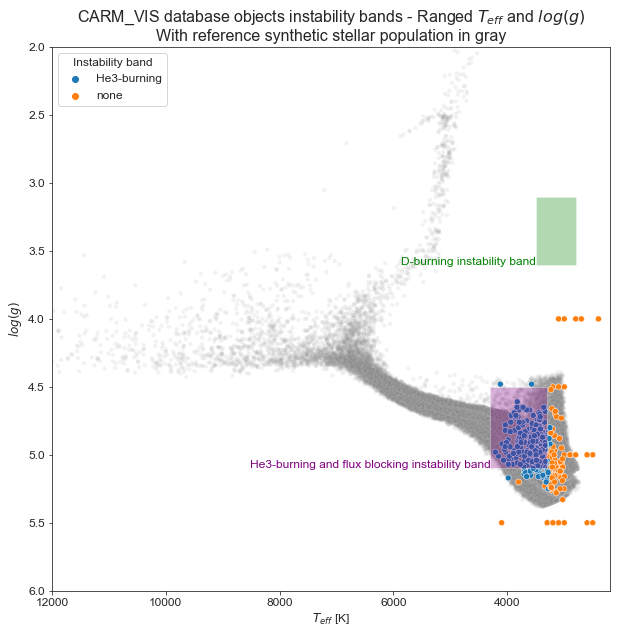

In [38]:
plt.figure(figsize=(10,10))
#ax = sns.scatterplot(data=gto, x='Teff_K', y='logg', hue='InstBand_ranged')
# Draw the synthetic population:
ax = sns.scatterplot(data=stellar_pop, x='Teff', y='log_g', color='gray', size=1.0, alpha=0.1,
                     legend=False)

# Set plot limits as per typical logg and Teff values in HR diagram.
x_min = 2200
x_max = 12000
y_min = 2.00
y_max = 6.00
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

# Add the synthetic population:
#sns.scatterplot(data=stellar_pop, x='Teff', y='log_g', color='gray', size=1.0, alpha=0.1,
#                ax=ax, legend=False)
# Add the GTO objetcs:
sns.scatterplot(data=gto, x='Teff_K', y='logg', hue='InstBand_ranged',
                ax=ax, legend=True)

# Add patches and label for instability regions:
ax.add_patch(mpatches.Rectangle((2800, 3.1), 700, 0.5, facecolor="green", alpha=0.30))
ax.text(3500, 3.6, "D-burning instability band", color="green", fontsize=12, ha='right')
ax.add_patch(mpatches.Rectangle((3300, 4.5), 1000, 0.6, facecolor="purple", alpha=0.30))
ax.text(4300, 5.1, "He3-burning and flux blocking instability band", color="purple", fontsize=12, ha='right')

# Set titles, sizes etc.
ax.set_title("CARM_VIS database objects instability bands - Ranged $T_{eff}$ and $log(g)$\n"
             "With reference synthetic stellar population in gray", fontsize=16)
ax.set_xlabel("$T_{eff}$ [K]", fontsize=12)
ax.set_ylabel("$log(g)$", fontsize=12)
ax.tick_params(axis='both', which='major', bottom=True, left=True, labelsize=12)
ax.invert_xaxis()
ax.invert_yaxis()
plt.legend(title="Instability band", title_fontsize='large',
           loc='upper left', fontsize=12)
plt.savefig(IMAGE_RANGED_OUT_ZOOM_HR)
plt.show();

**Observation:** some strange shape appears at the right end of the sysnthetic stellar population.

### Visualization of CARM_VIS objects with no light curve data

We now create an improved visualization, with _Aitoff_ projection:

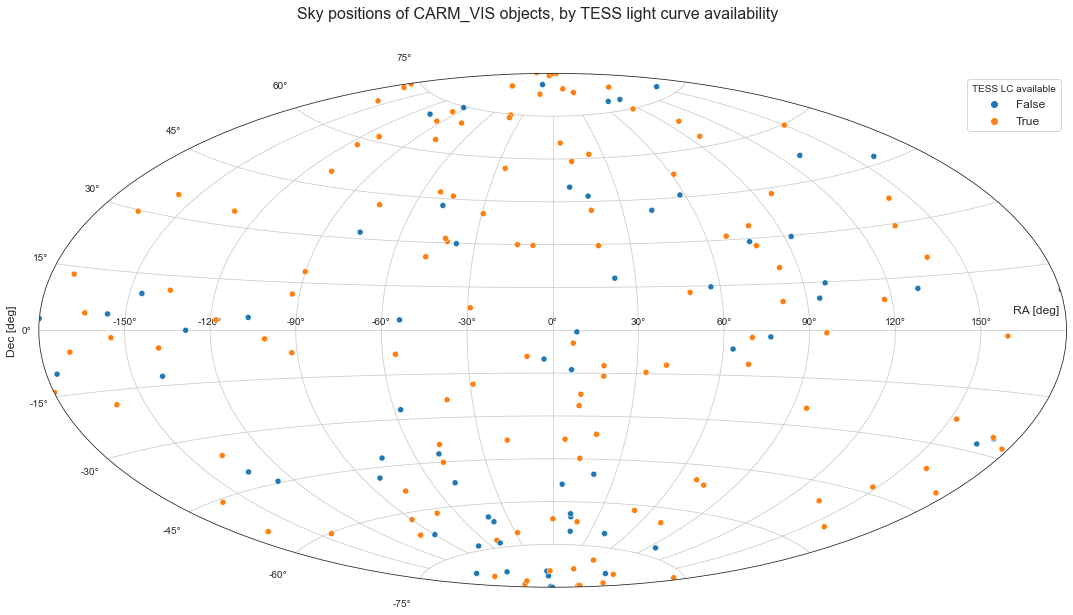

In [39]:
# Set up a grid of axes with a polar projection
g = sns.FacetGrid(data=gto,
                  subplot_kws=dict(projection='aitoff'), height=15,
                  sharex=False, sharey=False, despine=False)
# Draw a scatterplot onto each axes in the grid
g.map(sns.scatterplot, "RA_J2016_deg", "DE_J2016_deg", hue=gto['has_lc'])
#g.tight_layout()
g.fig.subplots_adjust(top=1.35)
g.fig.suptitle("Sky positions of CARM_VIS objects, by TESS light curve availability", fontsize=16)
g.axes[0,0].set_xlabel("RA [deg]", fontsize=12)
g.axes[0,0].xaxis.set_label_coords(0.97, 0.55)
g.axes[0,0].set_ylabel("Dec [deg]", fontsize=12)
g.axes[0,0].legend(title="TESS LC available",loc='upper right', fontsize=12)
g.axes[0,0].grid(True)
plt.savefig(IMAGE_NO_LC_GTO_LOCATION_AITOFF)
plt.show();

### CARMENES and CARM_VIS objects, located in a typical HR diagram (temperature - luminosity)

In [40]:
stellar_pop.columns

Index(['star_number', 'log(t[years])', 'Metallicity[Fe/H]', 'Mass[Mo]',
       'log(L/Lo)', 'log(Teff[K])', 'InitMassSec[Mo]', 'VarStarIdx',
       'Pulsating_log(P[days])', 'u', 'g', 'r', 'i', 'z', 'u-g', 'g-r', 'r-i',
       'i-z', 'log_g', 'Teff', 'Age [Gyr]', 'Age Range [Gyr]', 'ID Age Range',
       'Metallicity Range [Fe/H]', 'ID Metallicity Range'],
      dtype='object')

In [41]:
print(carmenes.columns.to_list())

['Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg', 'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg', 'Ref01', 'SpT', 'SpTnum', 'Ref02', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'Ref03', 'L_Lsol', 'eL_Lsol', 'Ref04', 'R_Rsol', 'eR_Rsol', 'Ref05', 'M_Msol', 'eM_Msol', 'Ref06', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'Ref07', 'pi_mas', 'epi_mas', 'Ref08', 'd_pc', 'ed_pc', 'Ref09', 'Vr_kms-1', 'eVr_kms-1', 'Ref10', 'ruwe', 'Ref11', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'Ref12', 'sa_m/s/a', 'esa_m/s/a', 'Ref13', 'SKG', 'Ref14', 'SKG_lit', 'Ref14_lit', 'Pop', 'Ref15', 'vsini_flag', 'vsini_kms-1', 'evsini_kms-1', 'Ref16', 'P_d', 'eP_d', 'Ref17', 'pEWHalpha_A', 'epEWHalpha_A', 'Ref18', 'log(LHalpha/Lbol)', 'elog(LHalpha/Lbol)', 'Ref19', '1RXS', 'CRT_s-1', 'eCRT_s-1', 'HR1', 'eHR1', 'HR2', 'eHR2', 'Flux_X_E-13_ergcm-2s-1', 'eFlux_X_E-13_ergcm-2s-1', 'LX/LJ', 'eLX/LJ', 'Ref20', 'Activity', 'Ref21', 'FUV_mag',

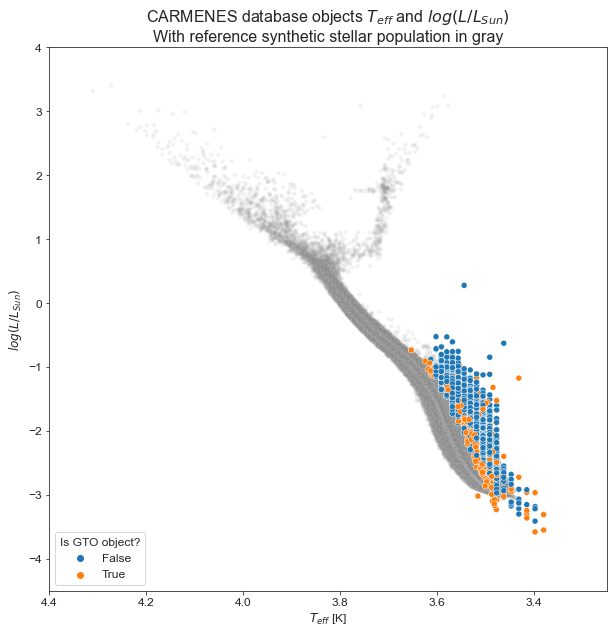

In [42]:
plt.figure(figsize=(10,10))
#ax = sns.scatterplot(data=gto, x='Teff_K', y='logg', hue='InstBand_ranged')
# Draw the synthetic population:
ax = sns.scatterplot(data=stellar_pop, x='log(Teff[K])', y='log(L/Lo)', color='gray', size=1.0, alpha=0.1,
                     legend=False)

# Set plot limits as per typical logg and Teff values in HR diagram.
x_min = 3.25
x_max = 4.40
y_min = -4.5
y_max = 4.0
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

# Add the synthetic population:
#sns.scatterplot(data=stellar_pop, x='Teff', y='log_g', color='gray', size=1.0, alpha=0.1,
#                ax=ax, legend=False)
# Add the CARMENES objetcs:
sns.scatterplot(data=carmenes, x=np.log10(carmenes['Teff_K']), y=np.log10(carmenes['L_Lsol']),
                hue='is_GTO', ax=ax, legend=True)

# Set titles, sizes etc.
ax.set_title("CARMENES database objects $T_{eff}$ and $log(L/L_{Sun})$\n"
             "With reference synthetic stellar population in gray", fontsize=16)
ax.set_xlabel("$T_{eff}$ [K]", fontsize=12)
ax.set_ylabel("$log(L/L_{Sun})$", fontsize=12)
ax.tick_params(axis='both', which='major', bottom=True, left=True, labelsize=12)
ax.invert_xaxis()
plt.legend(title="Is GTO object?", title_fontsize='large',
           loc='lower left', fontsize=12)
plt.savefig(IMAGE_HR_TEFF)
plt.show();

## Save newly modified data, CARM_VIS `NaN` rows and `NaN` count

In [43]:
gto_nan.to_csv(GTO_NAN_FILE, sep=',', decimal='.', index=True)

In [44]:
gto_nan_logg_teff.to_csv(GTO_NAN_RECORD_FILE, sep=',', decimal='.', index=False)

In [45]:
gto_no_lc.to_csv(GTO_NO_LC_FILE, sep=',', decimal='.', index=False)

In [46]:
carmenes.to_csv(OUTPUT_FILE, sep=',', decimal='.', index=False)

In [47]:
carmenes[carmenes['is_GTO'] == True].to_csv(GTO_OUTPUT_FILE, sep=',', decimal='.', index=False)

In [48]:
carmenes[carmenes['is_GTO'] == True].to_csv(GTO_OUT_PG_FILE, sep=',', decimal='.', index=False)

## Summary

**OBSERVATIONS AND CONCLUSIONS:**
- Instability bands:
  - From the CARM_VIS sample, we have 243 stars in the _"He3-burning"_ instability band ($\approx62\%$ of the sample).
  - If we take into account the error margins in the `logg` and `Teff_K` variables, the number increases to 279 stars ($\approx72\%$ of the sample))
  - The percentages in the _"He3-burning"_ instability bands for the sample of non-CARM_VIS stars are $\approx44\%$ (nominal) and $\approx48\%$ (ranged).
  - Hence, **a greater fraction of CARM_VIS stars are prone to belong to the _He3-burning_ instability band**.
  - No star in the total CARMENES sample is located in the _"D-burning"_ stability band.
  - Notice that some stars in the database have no `Teff_K` or `logg` values, so their belonging to instability bands is unknown:
    - 4 CARM_VIS stars have no `logg` value. All CARM_VIS stars have `Teff_K`value.
    - 560 non-CARM_vIS stars have no `Teff_K`value; 555 non-CARM_VIS stars have no `logg` value.
- **123 CARM_VIS objects ($\approx31\%$) do not have TESS light curve information**, and not all of them are located in a specific region of the sky:
  - 82 of them are in the He-3 burning instability band.